In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
df= pd.read_csv(r'C:\Users\Armado\Documents\GitProjects\EDA_Proyecto\data\raw\timeforcasting.csv')
df

,User ID,Order Id,Product Id,Price,Time
0,6365,10147,7575.0,175.0,2019-03-22T00:20:26+00:00
1,1,10148,7575.0,175.0,2019-03-22T00:20:26+00:00
2,0,10146,5633.0,4.5,2019-03-20T12:42:18+00:00
3,6290,10144,7574.0,175.0,2019-03-19T19:47:17+00:00
4,1,10145,5593.0,3.5,2019-03-19T19:47:17+00:00
...,...,...,...,...,...
1508,0,6067,NaN,20.0,2014-02-13T23:43:19+00:00
1509,0,6066,NaN,20.0,2014-02-13T21:04:30+00:00
1510,0,6065,NaN,20.0,2014-02-13T20:27:19+00:00
1511,5196,6064,NaN,20.0,2014-02-13T00:35:55+00:00


#Notas relativas al dataset:
Un User ID aparece multiples veces con diferentes Product ID con diferentes valores de Time,  esto sugiere que un usuario crea una orden de pedido, dento de la orden se recogen los diferentes productos. La Fecha y hora de la operación parece estar asignada poer orden.

In [59]:
''' Descriptivos'''
#a contiinuación se generan los descriptivos de las variables del dataset
df.describe(include='all')

,User ID,Order Id,Product Id,Price,Time
count,1513.000000,1513.000000,1460.000000,1513.000000,1513
unique,NaN,NaN,NaN,NaN,1499
top,NaN,NaN,NaN,NaN,2019-03-05T18:23:02+00:00
freq,NaN,NaN,NaN,NaN,2
mean,3108.943159,6844.588896,118.500000,112.688420,NaN
std,2520.000520,542.457749,888.892554,175.592896,NaN
min,0.000000,6064.000000,0.000000,0.000000,NaN
25%,0.000000,6441.000000,0.000000,12.000000,NaN
50%,3941.000000,6819.000000,0.000000,25.000000,NaN
75%,5311.000000,7197.000000,0.000000,144.000000,NaN


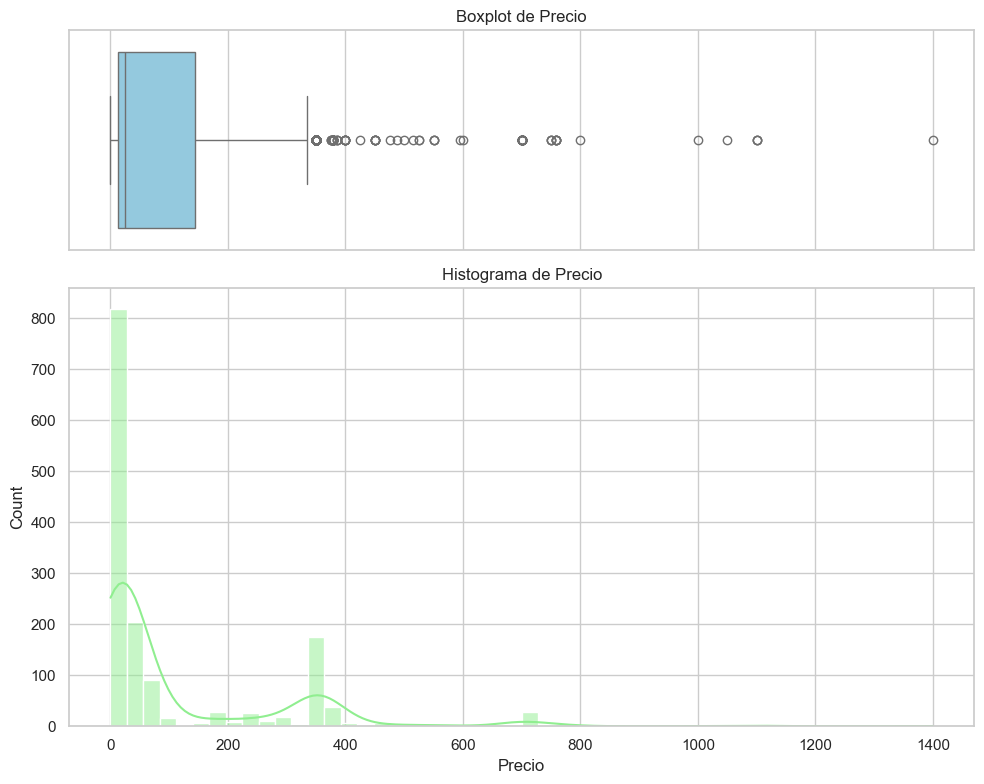

In [60]:

# Estilo visual
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [1, 2]})
# Boxplot
sns.boxplot(x=df['Price'], ax=axes[0], color='skyblue')
axes[0].set(title='Boxplot de Precio')
# Histograma
sns.histplot(x=df['Price'], ax=axes[1], bins=50, kde=True, color='lightgreen')
axes[1].set(title='Histograma de Precio', xlabel='Precio')
plt.tight_layout()
plt.show()

#Comentarios del descriptivo
 - Se puede observar que hay ciertos elementos de la columna User ID==0, esto se puede deber a datos faltantes, posiblemente por errores de sistema o de registro,  a veces tambien se usa un usuario neutro para hacer test de ordenes u opciones similares,  algo parecido pasa con el  user ID ==1.

 - Solo se tienen 1460 registrso validos para Product Id,  por lo que hay 53 valores faltantes.

 - La disperción de los datos es alta para la variable Price, hay demasiados productos con precio 0, la mayoría son menores de 400 pesos, pero el máximo es de 1400
- Adcionalmente hay 52 ordenes de producto distintas pero sin un producto asociado, aunque si tienen precio, la mayoría de estas ordenes pertenecen a Usuarios tipo 0.






In [61]:
df['Time'] = pd.to_datetime(df['Time'])
df['Time'] = df['Time'].dt.tz_localize(None)
df['year'] = df['Time'].dt.year
df['month'] = df['Time'].dt.month
df.head(5)

,User ID,Order Id,Product Id,Price,Time,year,month
0,6365,10147,7575.0,175.0,2019-03-22 00:20:26,2019,3
1,1,10148,7575.0,175.0,2019-03-22 00:20:26,2019,3
2,0,10146,5633.0,4.5,2019-03-20 12:42:18,2019,3
3,6290,10144,7574.0,175.0,2019-03-19 19:47:17,2019,3
4,1,10145,5593.0,3.5,2019-03-19 19:47:17,2019,3


In [62]:
df[df['User ID'].isin([0, 1])]

,User ID,Order Id,Product Id,Price,Time,year,month
1,1,10148,7575.0,175.0,2019-03-22 00:20:26,2019,3
2,0,10146,5633.0,4.5,2019-03-20 12:42:18,2019,3
4,1,10145,5593.0,3.5,2019-03-19 19:47:17,2019,3
6,1,10143,7574.0,175.0,2019-03-19 19:39:57,2019,3
8,1,10141,7575.0,175.0,2019-03-06 23:20:42,2019,3
...,...,...,...,...,...,...,...
1506,0,6069,NaN,20.0,2014-02-14 17:51:38,2014,2
1507,0,6068,NaN,20.0,2014-02-14 15:42:10,2014,2
1508,0,6067,NaN,20.0,2014-02-13 23:43:19,2014,2
1509,0,6066,NaN,20.0,2014-02-13 21:04:30,2014,2


# Mantenemos usuarios 0 o 1?
Se percibe que la cantidad de registros que pertenecen a usuarios 0 o 1 son aprox la tercera parte del total (37%) por lo que es importante estar seguros de que al quitarlos no se perderá una parte importante de los datos.

    - Veamos si tiene un Producto ID valido, buscando la proporción de esos registros que  tiene un Product Id.
    - Tabien se busca saber si existe un precio para esos registros.
    - Revisamos si tienen fechas validas
    - Verificamos las ordenes distintas para esos registros



# Criterio para saber si eliminar los registros User ID in (0, 1)

Sí la proporción de tales registros que tiene un Product Id valido es pequeña, significa que en general los usuarios 0 y 1 no son relevantes ya que no continen ordenes con productos validos: se usa notna para comparar. se usa tambien "!=0"

Si tiene precios inconsistentes, se pueden eliminar

Si no cuentan con un registro valido de fecha, se pueden eliminar

Si los Product_ID==0 pueden ser productos no válidos, si la proporcion es baja se podrían eliminar


In [63]:
# tabla pivote: frecuencia de Product ID
pivot_product = pd.pivot_table(df, 
                             index='Product Id',
                             aggfunc='size',
                             fill_value=0)
pivot_product.sort_values(ascending=False).head(10)

Product Id
0.0       1434
5756.0      11
7574.0       7
7575.0       6
5593.0       1
5633.0       1
dtype: int64

In [64]:
# tabla pivote: frecuencia de Product ID
pivot_product = pd.pivot_table(df, 
                             index='Price',
                             aggfunc='size',
                             fill_value=0)
pivot_product.sort_values(ascending=False).head(10)

Price
350.00    174
0.00       62
20.00      54
21.00      44
9.00       43
10.50      34
35.00      31
378.88     31
14.00      31
3.50       31
dtype: int64

In [65]:
print("proporcion de nulos:")
print(1-df[df['User ID'].isin([0, 1])]['Product Id'].notna().mean())
mask = df['User ID'].isin([0, 1])
print("proporcion de ceros ó nulos:")
prop_basura = ((df.loc[mask, 'Product Id'].isna()) | (df.loc[mask, 'Product Id'] == 0)).mean()
print(prop_basura)

proporcion de nulos:
0.07964601769911506
proporcion de ceros ó nulos:
0.9699115044247788


# Limpieza del dataset

La proporcion de registros invalidaos por ser nulls en Porduct ID es del 7%, pero la proporcion de datos nulls con datos ==0 para elñ mismo campo es mas del 90%

En conclusión no se pueden eliminar tan facil los registros de los usuarios 1, 0.

Sin embargo, queda claro que las ventas =0 no reflejan informacion de ventas reales.

Priorizando la entrega del proyecto bajo las mejores condiciones asequibles, se opta por continuar con la limpieza sin eliminar tantos registros. No obstante es necesario realizar 3 preguntas a los data owners o reunirse con el área comercial: 1.- ¿Que representan los usuarios 0, 1? 2.- ¿A qué se refieren los precios = 0? ¿A qué se debe la ausencia de registros de Product ID y Product ID ==0?

Se decide que la limpieza de los datos solo implicará df['Price'] > 0 y se imputarán los datos nulls de Product ID con ceros

In [66]:
df = df[df['Price'] > 0].copy()
df['Product Id'] = df['Product Id'].fillna(0)
df['Product Id'] = df['Product Id'].astype(int)
df

,User ID,Order Id,Product Id,Price,Time,year,month
0,6365,10147,7575,175.0,2019-03-22 00:20:26,2019,3
1,1,10148,7575,175.0,2019-03-22 00:20:26,2019,3
2,0,10146,5633,4.5,2019-03-20 12:42:18,2019,3
3,6290,10144,7574,175.0,2019-03-19 19:47:17,2019,3
4,1,10145,5593,3.5,2019-03-19 19:47:17,2019,3
...,...,...,...,...,...,...,...
1508,0,6067,0,20.0,2014-02-13 23:43:19,2014,2
1509,0,6066,0,20.0,2014-02-13 21:04:30,2014,2
1510,0,6065,0,20.0,2014-02-13 20:27:19,2014,2
1511,5196,6064,0,20.0,2014-02-13 00:35:55,2014,2


In [73]:
# Ordenar precios de menor a mayor
df_sorted = df.sort_values('Price', ascending=True)
print("Distribución de precios ordenados:")
print("\nPrimeros 10 precios más bajos:")
print(df_sorted['Price'].head(10))
print("\nÚltimos 10 precios más altos:")
print(df_sorted['Price'].tail(10))

Distribución de precios ordenados:

Primeros 10 precios más bajos:
800     2.5
4       3.5
648     3.5
1387    3.5
1350    3.5
701     3.5
720     3.5
61      3.5
1329    3.5
1295    3.5
Name: Price, dtype: float64

Últimos 10 precios más altos:
1322     757.75
1213     757.75
1283     757.75
1066     800.00
116     1000.00
119     1050.00
810     1100.00
849     1100.00
1049    1100.00
939     1400.00
Name: Price, dtype: float64


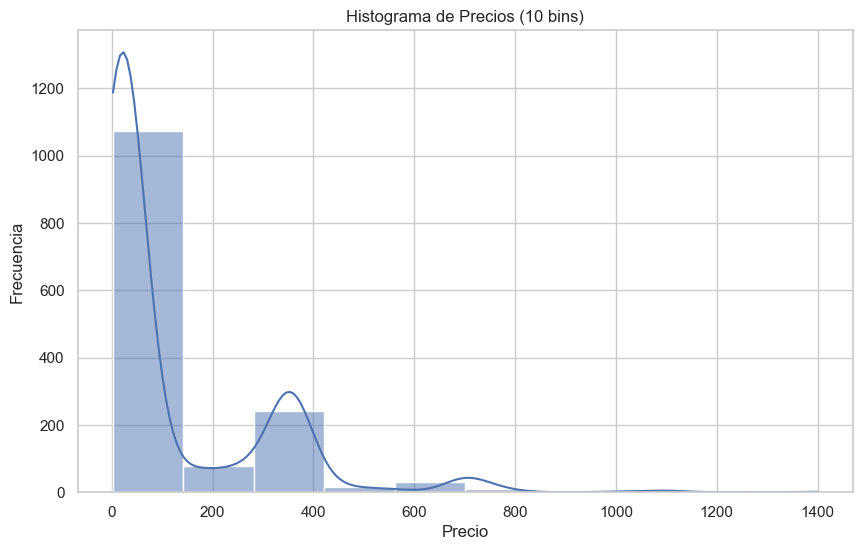

In [74]:
# Crear histograma con 10 bins
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Price', bins=10, kde=True)
plt.title('Histograma de Precios (10 bins)')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()